In [5]:
import tensorflow as tf
print(tf.__version__)

2.18.0


Found 1981 images belonging to 2 classes.
Found 494 images belonging to 2 classes.
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 47s 716ms/step - accuracy: 0.6222 - loss: 0.7009 - val_accuracy: 0.8219 - val_loss: 0.3983
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 361ms/step - accuracy: 0.8432 - loss: 0.3705 - val_accuracy: 0.7955 - val_loss: 0.4356
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 351ms/step - accuracy: 0.8572 - loss: 0.3756 - val_accuracy: 0.8947 - val_loss: 0.3125
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 377ms/step - accuracy: 0.9388 - loss: 0.2680 - val_accuracy: 0.9393 - val_loss: 0.1665
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 381ms/step - accuracy: 0.9538 - loss: 0.1578 - val_accuracy: 0.9211 - val_loss: 0.2302
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.9500 - loss: 0.1834 - val_accuracy: 0.9595 - val_loss: 0.1256
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.9691 - loss: 0.1121 - val_accuracy: 0.9332 - val_loss: 0.1652
Epoch 8/10
62/

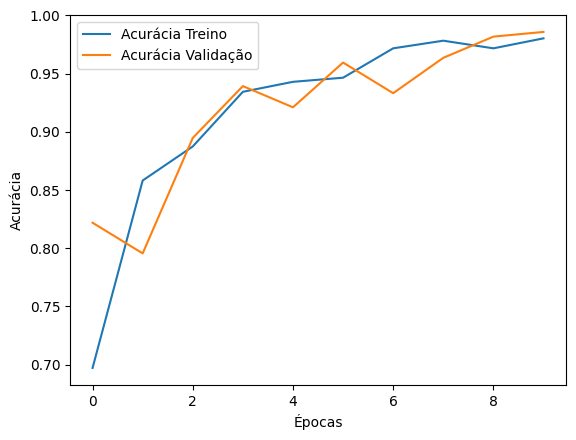

In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Caminho do dataset
dataset_path = "PlantVillage"

# Classes específicas a serem usadas
selected_classes = ["Pepper_bell_bacterial_spot", "Pepper_bell_healthy"]

# Criar gerador de imagens com aumento de dados
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% treino, 20% validação
)

# Carregar dados de treinamento e validação
train_generator = datagen.flow_from_directory(
    dataset_path,
    classes=selected_classes,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    classes=selected_classes,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Criando a CNN
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')  # Apenas 2 classes
])

# Compilar modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Treinamento do modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

# Salvar modelo treinado
model.save("plant_disease_model_2_classes.h5")

# Exibir gráfico de precisão
plt.plot(history.history['accuracy'], label='Acurácia Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.show()
